100%|██████████| 10000/10000 [04:01<00:00, 41.44it/s]


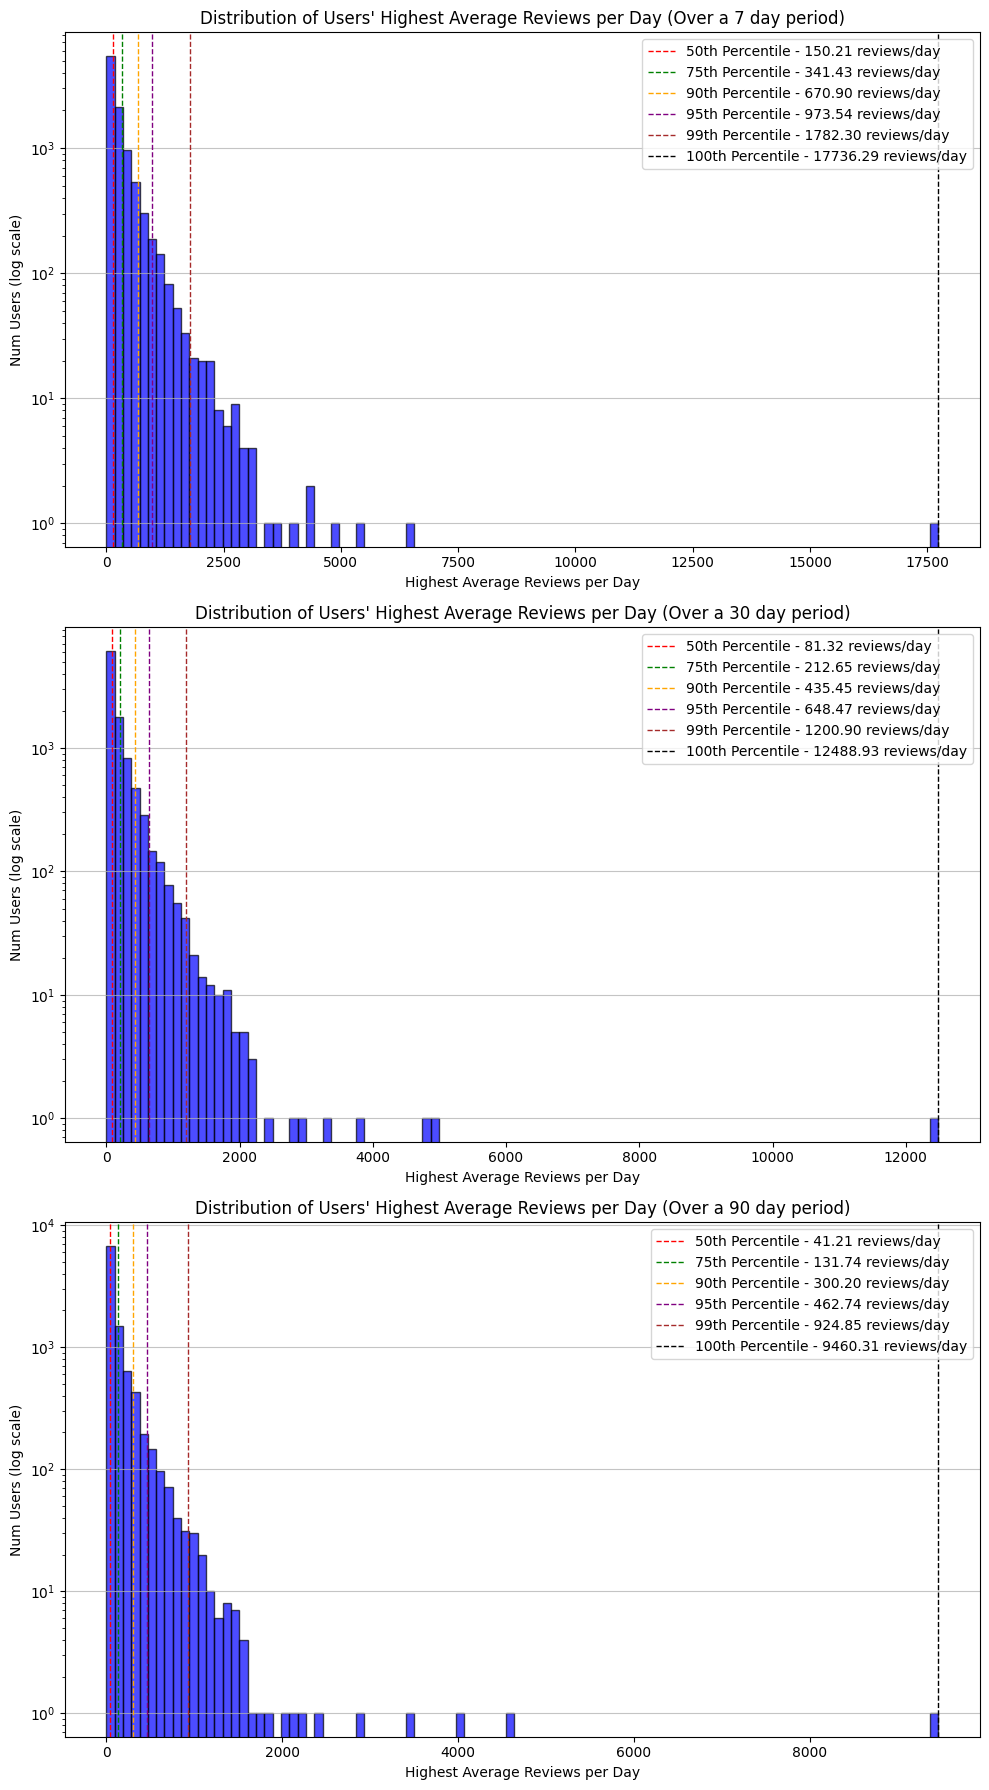

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

dataset_path = '../../anki-revlogs-10k/revlogs/'
window_sizes = [7, 30, 90]  # Size of the windows - 30 means: for each user, find their best 30-day period (where they did the most reviews)

daily_reviews = []
largest_averages = {w: [] for w in window_sizes}
i = 0
for file in tqdm(list(Path(dataset_path).iterdir()), smoothing=0):
    i += 1
    user_id = str(i)
    dataset = pd.read_parquet(dataset_path + "//user_id=" + user_id)
    daily_reviews.append(len(dataset) / (max(dataset['day_offset']) + 1))
    day_review_counts = dataset["day_offset"].value_counts().sort_index().to_dict()
    # This is the number of reviews per day for user i
    # Go from the first to last day, and save the highest average number of reviews per day, over a window of size window_size
    # Note that some days may have no reviews, and will not be included in the dictionary
    for window_size in window_sizes:
        largest_average = 0
        for j in range(len(day_review_counts) - window_size + 1):
            window_sum = sum(
                day_review_counts.get(k, 0) for k in range(j, j + window_size)
            )
            average = window_sum / window_size
            if average > largest_average:
                largest_average = average
        largest_averages[window_size].append(largest_average)

# Plots
fig, axs = plt.subplots(len(window_sizes), 1, figsize=(10, 6 * len(window_sizes)))
quantiles = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
colours = ['red', 'green', 'orange', 'purple', 'brown', 'black']
for idx, window_size in enumerate(window_sizes):
    axs[idx].hist(largest_averages[window_size], bins=100, alpha=0.7, color='blue', edgecolor='black')
    for quantile, colour in zip(quantiles, colours):
        quantile_value = pd.Series(largest_averages[window_size]).quantile(quantile)
        label = f'{int(quantile * 100)}th Percentile - {quantile_value:.2f} reviews/day'
        axs[idx].axvline(quantile_value, color=colour, linestyle='dashed', linewidth=1, label=label)
    axs[idx].set_title(f'Distribution of Users\' Highest Average Reviews per Day (Over a {window_size} day period)')
    axs[idx].set_yscale('log')
    axs[idx].set_ylabel('Num Users (log scale)')
    axs[idx].set_xlabel('Highest Average Reviews per Day')
    axs[idx].legend(loc='upper right')
    axs[idx].grid(axis='y', alpha=0.75)
# plt.xlabel('Highest Average Reviews per Day')
plt.tight_layout()
plt.show()
